In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline

### Read the dataset 

In [2]:
users = pd.read_csv('takehome_users.csv',encoding='latin')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
usage = pd.read_csv('takehome_user_engagement.csv')
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


### Missing values in 'last_session_creation_time' and 'invited_by_user_id'
* Fill the null values 
* sync up the column names
* set the data time values 

In [5]:
users.rename(columns={'object_id': 'user_id'}, inplace=True)
from datetime import datetime
users = users.fillna(0)

users['last_session_creation_time'] = users['last_session_creation_time'].apply(
    lambda x: datetime.strptime(str(datetime.fromtimestamp(float(int(x)))), '%Y-%m-%d %H:%M:%S'))
users['creation_time'] = users['creation_time'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))


In [6]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### No missing values in the usage table
* set the data time values 

In [7]:
usage['time_stamp'] = pd.to_datetime(usage['time_stamp'])

### Add the visit count to User dataframe

In [8]:
usage_grouped = usage.groupby('user_id',as_index=False).agg({'visited': 'sum'})
merged = users.merge(usage_grouped, how='left', on='user_id')
merged.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 22:53:30,1,0,11,10803.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 22:45:04,0,0,1,316.0,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 18:14:52,0,0,94,1525.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 03:09:28,0,0,1,5151.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 04:14:20,0,0,193,5240.0,1.0


In [9]:
def check_3logins_in_week(user):
    # get the loginlist from usage table
    loglist = usage[usage['user_id'] == user]
    loglist = loglist.reset_index()
 
    # check for 3 logins in a week 
    for i in range(len(loglist)-2):
        stime = loglist['time_stamp'][i]
        etime = loglist['time_stamp'][i+2]
        if ((etime - stime) < pd.Timedelta('7D')): 
            return 1
    return 0

In [10]:
# loop over each user and check if they meet the adopted user criteria
adopted = pd.Series(np.random.randn(len(merged)))
invited = pd.Series(np.random.randn(len(merged)))
for index,row in merged.iterrows():
    adopted[index] = 0
    invited[index] = 0 
    
    if row['invited_by_user_id'] >=1:
        invited[index] = 1   # user has been invited by another user
    if row['visited'] >=3 :
        adopted[index]=check_3logins_in_week(row['user_id'])
        
merged["adopteduser"] = adopted
merged["invited"] = invited

In [11]:
# calculate active days 
merged['daysactive'] = merged['last_session_creation_time'] - merged['creation_time']
merged['daysactive'] = merged['daysactive'].apply(lambda x: abs(x.total_seconds()/60/60/24/30)) 

In [12]:
merged.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopteduser,invited,daysactive
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 22:53:30,1,0,11,10803.0,1.0,0.0,1.0,0.006944
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 22:45:04,0,0,1,316.0,14.0,1.0,1.0,4.526389
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 18:14:52,0,0,94,1525.0,1.0,0.0,1.0,0.006944
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 03:09:28,0,0,1,5151.0,1.0,0.0,1.0,0.026389
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 04:14:20,0,0,193,5240.0,1.0,0.0,1.0,0.158333


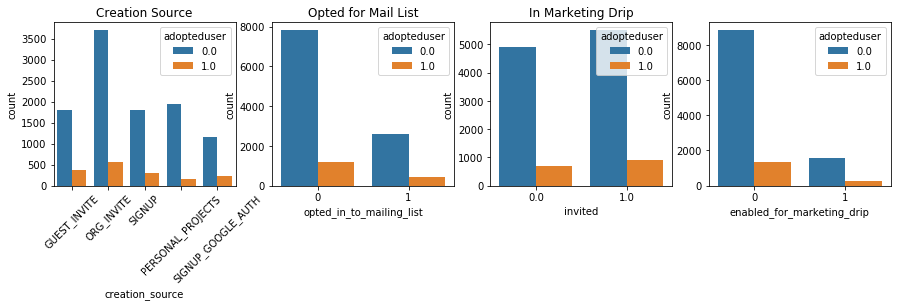

In [13]:
%matplotlib inline
fig, axs = plt.subplots(1,4,figsize=(15,3))
axs[0].set_title("Creation Source")
axs[1].set_title("Opted for Mail List")
axs[2].set_title("Invited by Users")
axs[2].set_title("In Marketing Drip")
sns.countplot(x='creation_source', hue='adopteduser', data=merged,ax=axs[0])
sns.countplot(x='opted_in_to_mailing_list', hue='adopteduser', data=merged,ax=axs[1])
sns.countplot(x='invited', hue='adopteduser', data=merged,ax=axs[2])
sns.countplot(x='enabled_for_marketing_drip', hue='adopteduser', data=merged,ax=axs[3])
#plt.xticks(x_val, xlabels, rotation='vertical')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)


### Lets build the classification model

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
merged["creation_src"]=le.fit_transform(merged['creation_source'])

In [15]:

cols = ['user_id','creation_time', 'name', 'email', 'creation_source', 'invited_by_user_id','visited','last_session_creation_time']
merged = merged.drop(cols,axis=1)


In [16]:
merged.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopteduser,invited,daysactive,creation_src
0,1,0,11,0.0,1.0,0.006944,0
1,0,0,1,1.0,1.0,4.526389,1
2,0,0,94,0.0,1.0,0.006944,1
3,0,0,1,0.0,1.0,0.026389,0
4,0,0,193,0.0,1.0,0.158333,0


In [18]:
y = merged["adopteduser"]
X = merged.drop(["adopteduser"],axis=1)

X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,daysactive,creation_src
0,1,0,11,1.0,0.006944,0
1,0,0,1,1.0,4.526389,1
2,0,0,94,1.0,0.006944,1
3,0,0,1,1.0,0.026389,0
4,0,0,193,1.0,0.158333,0


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier

In [20]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 7 columns):
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
adopteduser                   12000 non-null float64
invited                       12000 non-null float64
daysactive                    12000 non-null float64
creation_src                  12000 non-null int64
dtypes: float64(3), int64(4)
memory usage: 1.0 MB


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3083   31]
 [  53  433]]
             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99      3114
        1.0       0.93      0.89      0.91       486

avg / total       0.98      0.98      0.98      3600



## Feature Extraction

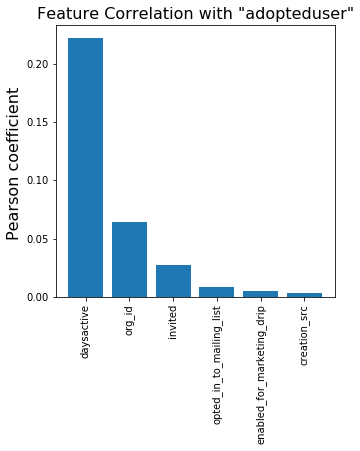

In [23]:
def display_corr(dataset, target):
    corr_matrix = dataset.corr()
    corr = corr_matrix[target].copy()
    abs_corr = corr.apply(lambda x: abs(x))
    
    sorted_values = abs_corr.sort_values(ascending=False)
    y_val = list(sorted_values.values)[1:]
    x_val = range(0,len(y_val))
    
    xlabels = list(sorted_values.keys())[1:]
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.bar(x_val, y_val)
    ax.set_title('Feature Correlation with "{}"'.format(target), fontsize=16)
    ax.set_ylabel('Pearson coefficient ', fontsize=16)
    plt.xticks(x_val, xlabels, rotation='vertical')
    plt.show()
 
display_corr(merged, 'adopteduser')

### Predictive Modeling - Summary

From the correleration matrix (pearson coefficients) we see that the key factors impacting the adoption rate of the Relax inc are - last session time,the organization they belong to , invite from other users , signup for mailing lists and marketing drips

The classification model using GradientBoostingClassifier performs quite well with very high f1-score . 